In [1]:
!pip install ultralytics

from IPython import display
display.clear_output()
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.80 🚀 Python-3.10.12 torch-2.3.1+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.6/107.7 GB disk)



image 1/1 /content/Q3_pose.png: 448x640 12 persons, 193.7ms
Speed: 4.2ms preprocess, 193.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

 8 Persons detected.


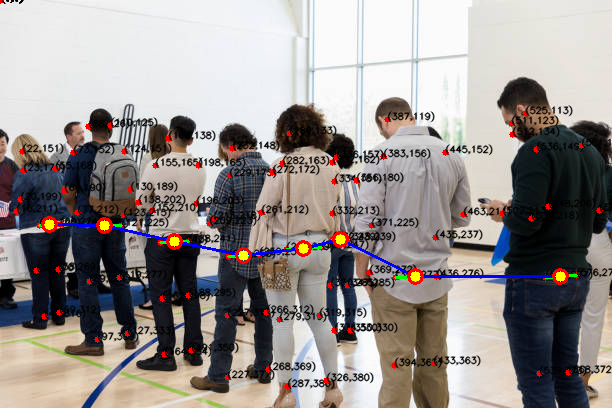

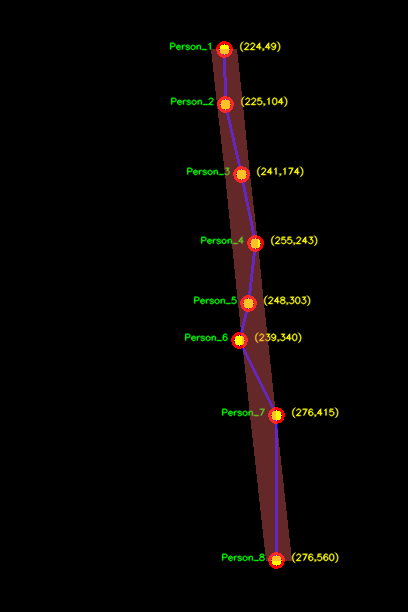

In [9]:
import cv2
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
from scipy import stats

# Function to detect significant poses
def significant_pose_detection(arr, th):
    n = len(arr)
    i = 0
    for itemm in arr:
        if np.sum(itemm[0] + itemm[1]) != 0:
            i = i + 1
    sig_det = (i / n)
    return 1 if sig_det >= th else 0

# Load YOLO model
model = YOLO('yolov8n-pose.pt')

image_file_name = "Q3_pose.png"
img = cv2.imread(image_file_name)
results = model.predict(image_file_name)[0]
th = 0.3

Q = []
det = 0
concat_df = pd.DataFrame()

# Processing the results from YOLO
for result in results:
    landmarks = []
    kpts = result.keypoints
    nk = kpts.shape[1]

    for i in range(nk):
        keypoint = kpts.xy[0, i]
        x, y = int(keypoint[0].item()), int(keypoint[1].item())
        landmarks.append([x, y])

    detections = significant_pose_detection(landmarks, th)
    if detections == 1:
        det = det + 1
        for j in range(len(landmarks)):
            x = landmarks[j][0]
            y = landmarks[j][1]
            cv2.circle(img, (x, y), 3, (0, 0, 255), -1)
            ttext = "(" + str(x) + "," + str(y) + ")"
            cv2.putText(img, ttext, (x, y), cv2.FONT_HERSHEY_SIMPLEX,
                        0.3, (0, 0, 0), 1, cv2.LINE_AA)

        df = pd.DataFrame(landmarks, columns=['x' + str(det), 'y' + str(det)], dtype=float)
        concat_df = pd.concat([concat_df, df], axis=1)

        cv2.line(img, landmarks[11], landmarks[12], (0, 255, 0), 2)
        a = (landmarks[11][0] + landmarks[12][0]) // 2
        b = (landmarks[11][1] + landmarks[12][1]) // 2
        Q.append([a, b])

m = list(map(lambda l: [v for v in l if v != 0], sorted(Q)))
nQ = [ele for ele in m if ele != []]
k = len(nQ)

# Draw lines and centroids between persons
i = 0
while i < (k - 1):
    cv2.line(img, nQ[i], nQ[i + 1], (255, 0, 0), 2)
    i = i + 1

i = 0
while i < k:
    cv2.circle(img, nQ[i], 5, (0, 255, 255), -1)
    cv2.circle(img, nQ[i], 7, (0, 0, 255), 2)
    i = i + 1

concat_df.to_csv('detected_pose.csv')
df_nQ = pd.DataFrame(nQ, columns=['x', 'y'], dtype=int)
df_nQ.to_csv('nQ_centroids.csv')

print("\n", k, "Persons detected.")
cv2.imwrite("output.jpg", img)
cv2_imshow(img)

# Load the image and initialize the canvas
image_file_name = "output.jpg"
src = cv2.imread(image_file_name)
h, w, c = src.shape
canva = np.zeros([h, w, 3], dtype=np.uint8)

nQT = [[itemm[1], itemm[0]] for itemm in nQ]

# Draw lines between persons
i = 0
while i < (k - 1):
    cv2.line(canva, nQ[i], nQ[i + 1], (255, 0, 0), 2)
    i = i + 1

# Draw centroids for each person
i = 0
while i < k:
    cv2.circle(canva, nQ[i], 5, (0, 255, 255), -1)
    cv2.circle(canva, nQ[i], 7, (0, 0, 255), 2)
    i = i + 1

canva = cv2.rotate(canva, cv2.ROTATE_90_CLOCKWISE)
image = cv2.flip(canva, 1)

# Add labels for each person
i = 0
while i < k:
    ttext = "(" + str(nQT[i][0]) + "," + str(nQT[i][1]) + ")"
    cv2.putText(image, ttext, (nQ[i][1] + 15, nQ[i][0]), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 255), 1, cv2.LINE_AA)
    cv2.putText(image, "Person_" + str(i + 1), (nQT[i][0] - 55, nQT[i][1]), cv2.FONT_HERSHEY_SIMPLEX,
                0.3, (0, 255, 0), 1, cv2.LINE_AA)
    i = i + 1

# Add the optimal line with 95% confidence interval
url = 'nQ_centroids.csv'
data = pd.read_csv(url)
x = data['x'].values
y = data['y'].values

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Predicted values
y_pred = intercept + slope * x
residuals = y - y_pred
residuals_std = np.std(residuals)

# Calculate 95% confidence intervals
ci_lower = y_pred - 1.440 * residuals_std
ci_upper = y_pred + 1.440 * residuals_std

outliers = np.where((y < ci_lower) | (y > ci_upper))
# Draw the confidence interval area
pts_lower = np.array([[int(ci_lower[i]),x[i]] for i in range(len(x))])
pts_upper = np.array([[int(ci_upper[i]),x[i]] for i in range(len(x))])
pts = np.vstack([pts_lower, pts_upper[::-1]])  # Stack lower and upper points


overlay = image.copy()

# Fill the confidence interval region
cv2.fillPoly(overlay, [pts], (100, 100, 250))

alpha = 0.4  # Transparency factor: 0.0 - fully transparent, 1.0 - fully opaque
cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0, image)

# Plot the regression line
# for i in range(len(x) - 1):
#     cv2.line(image, (int(y_pred[i]),x[i]), (int(y_pred[i + 1]),x[i + 1]), (255, 255, 0), 2)

# for idx in outliers[0]:
#     cx, cy = nQ[idx]
#     cv2.rectangle(image, (cy - 10, cx - 10), (cy + 10, cx + 10), (0, 0, 255), 2)

# Save and display the final image
cv2.imwrite("final_canvas.jpg", image)
cv2_imshow(image)